# ASL Classification with a CNN

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Get reproducible results
random_state = 46
tf.random.set_seed(random_state)

Using TensorFlow backend.


## GPU configuration
If you have a GPU, enable experimental memory growth.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## File Paths

In [3]:
train_dir = "asl_alphabet_train/asl_alphabet_train"
test_dir = "asl_alphabet_test/asl_alphabet_test"

## Train model

In [4]:
def fit_model(model, train_generator, val_generator):
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    model.summary()
    
    print('Fitting model...')
    history = model.fit(train_generator, 
        steps_per_epoch=100, 
        epochs=30, 
        verbose=1, 
        validation_data=val_generator, 
        validation_steps=50,
        use_multiprocessing=True,
        workers=8,
        callbacks=[
                keras.callbacks.ModelCheckpoint(filepath='model_bestAccuracy.h5', monitor='accuracy', save_best_only = True),
                keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta = 0.01, patience = 2, restore_best_weights = True)
            ])
    
    print('Evaluating model...')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    
    del model
    K.clear_session()


def fit_with_base_model(base_model, trainable = False):
    print("Defining train data generator...")
    datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,
        featurewise_std_normalization=False,
        rotation_range=30,
        validation_split=0.30)
    
    train_generator = datagen.flow_from_directory(
        train_dir,
        subset='training',
        target_size=(200, 200),
        batch_size=128,
        class_mode='sparse'
    )
    
    val_generator = datagen.flow_from_directory(
        train_dir,
        subset='validation',
        target_size=(200, 200),
        batch_size=128,
        class_mode='sparse'
    )
    
    base_model.trainable = trainable
    fit_model(tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(29)
    ]), train_generator, val_generator)
    

# Base models

## VGG16
This model uses VGG16 as a base model initialized with the ImageNet weights.  

Found 60900 images belonging to 29 classes.
Found 26100 images belonging to 29 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 29)                3741      
Total params: 14,784,093
Trainable params: 69,405
Non-trainable params: 14,714,688
_________________________________________________________________
Fitting model..

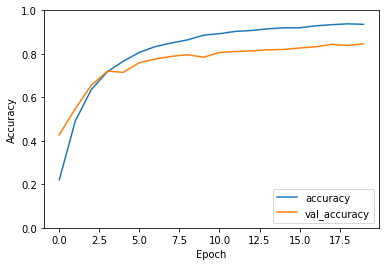

In [16]:
datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False,
    featurewise_std_normalization=False,
    samplewise_center=True,
    samplewise_std_normalization=True,
    brightness_range = (0.5,1.5),
    rotation_range=20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    validation_split=0.30)

train_generator = datagen.flow_from_directory(
    train_dir,
    subset='training',
    target_size=(224, 224),
    batch_size=128,
    class_mode='sparse'
)

val_generator = datagen.flow_from_directory(
    train_dir,
    subset='validation',
    target_size=(224, 224),
    batch_size=128,
    class_mode='sparse'
)

base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
base_model.trainable = False

fit_model(tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(29)
]), train_generator, val_generator)

### In case, a kernel is interrupted, to free up GPU memory, run:

In [ ]:
try: 
    del model
except NameError: model = None

K.clear_session()